# Notebook 5: Classification Model

## Upload Matrices

In [1]:
import numpy as np
import pandas as pd
import os

# Set folder path
folder_path = "/kaggle/input/fc-matrices/fc_matrices" 

subject_ids = range(1, 33)

all_fc_matrices = []
all_labels = []
valid_subjects = []

for sub_id in subject_ids:
    sub_name = f"sub-S{sub_id:02d}"
    fc_path = os.path.join(folder_path, f"{sub_name}_fc.npy")
    label_path = os.path.join(folder_path, f"{sub_name}_labels.csv")

    if os.path.exists(fc_path) and os.path.exists(label_path):
        fc_matrix = np.load(fc_path)
        labels = pd.read_csv(label_path)

        all_fc_matrices.append(fc_matrix)
        all_labels.append(labels)
        valid_subjects.append(sub_name)

# Print one subject
print(f"Example Subject: {valid_subjects[0]}")
print("FC matrix shape:", all_fc_matrices[0].shape)
print("Labels head:\n", all_labels[0].head())

Example Subject: sub-S01
FC matrix shape: (91, 100, 100)
Labels head:
    window_start_TR  mean_scaled_anxiety binned_by_mean
0               72             0.281827         medium
1               77             0.289161         medium
2               82             0.264760         medium
3               87             0.240351         medium
4               92             0.216425         medium


In [2]:
## PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Flatten (num_windows, N, N) to (num_windows, N*N)
flattened_data = []

for fc_matrix in all_fc_matrices:
    num_windows = fc_matrix.shape[0]
    flattened = fc_matrix.reshape(num_windows, -1)  # (num_windows, N*N)
    flattened_data.append(flattened)

# Concatenate across subjects, (total_windows, N*N)
X = np.vstack(flattened_data)
print("Combined shape for PCA:", X.shape)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

print("PCA result shape:", X_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)


Combined shape for PCA: (2730, 10000)
PCA result shape: (2730, 10)
Explained variance ratio: [0.29781926 0.02903762 0.02755719 0.02423101 0.02098115 0.01947196
 0.01718285 0.01665066 0.01589005 0.01324007]


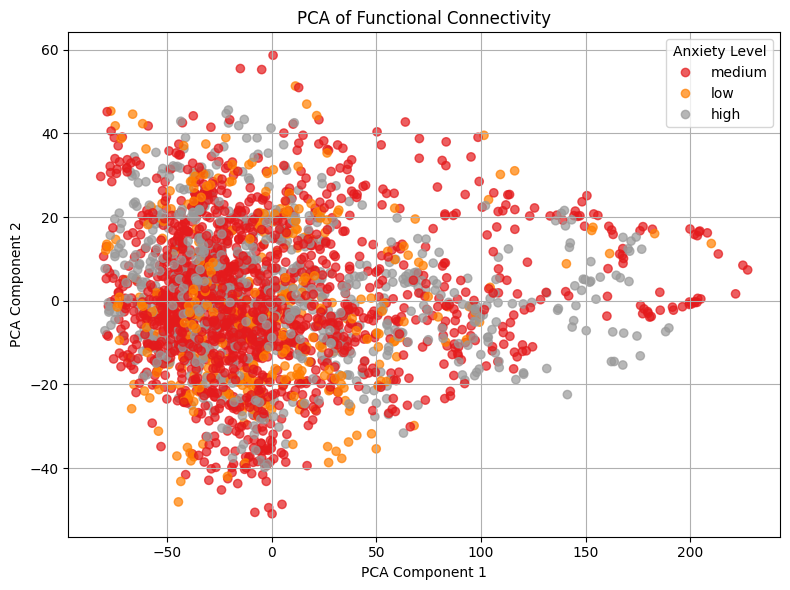

In [3]:
## Visualize results
import matplotlib.pyplot as plt
import pandas as pd

# Convert anxiety labels to numeric codes for plotting
anxiety_classes = []

for labels_df in all_labels:
    anxiety_classes.extend(labels_df['binned_by_mean'].values)

anxiety_classes = np.array(anxiety_classes)
anxiety_codes, unique_labels = pd.factorize(anxiety_classes)

plt.figure(figsize=(8, 6))

# Scatter plot from first two PCA components, color-coded by anxiety class
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=anxiety_codes,
    cmap='Set1',
    alpha=0.7
)

handles = scatter.legend_elements()[0]
plt.legend(handles=handles, labels=list(unique_labels), title="Anxiety Level")

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Functional Connectivity')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(anxiety_classes)


subject_ids_expanded = []
for i, sub_name in enumerate(valid_subjects):
    n_windows = all_fc_matrices[i].shape[0]
    subject_ids_expanded.extend([sub_name] * n_windows)
subject_ids_expanded = np.array(subject_ids_expanded)

# Subject-aware train/test split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_pca, y, groups=subject_ids_expanded))

X_train, X_test = X_pca[train_idx], X_pca[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
}

# Train and evaluate
for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


 Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

        high       0.41      0.11      0.18       150
         low       0.86      0.08      0.14        78
      medium       0.60      0.93      0.73       318

    accuracy                           0.59       546
   macro avg       0.62      0.37      0.35       546
weighted avg       0.58      0.59      0.49       546

Confusion Matrix:
[[ 17   0 133]
 [  4   6  68]
 [ 20   1 297]]

 Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

        high       0.39      0.15      0.22       150
         low       0.14      0.01      0.02        78
      medium       0.58      0.87      0.69       318

    accuracy                           0.55       546
   macro avg       0.37      0.35      0.31       546
weighted avg       0.46      0.55      0.47       546

Confusion Matrix:
[[ 23   0 127]
 [  1   1  76]
 [ 35   6 277]]

 Model: SVM

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


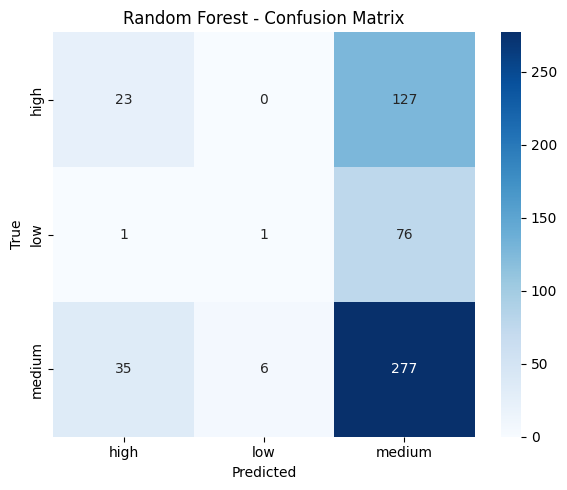

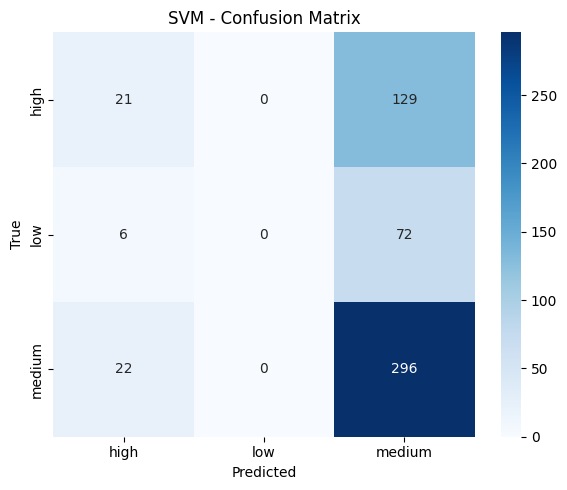

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Plot Random Forest
plot_confusion_matrix(y_test, models["Random Forest"].predict(X_test), "Random Forest", label_encoder.classes_)

# Plot SVM
plot_confusion_matrix(y_test, models["SVM"].predict(X_test), "SVM", label_encoder.classes_)


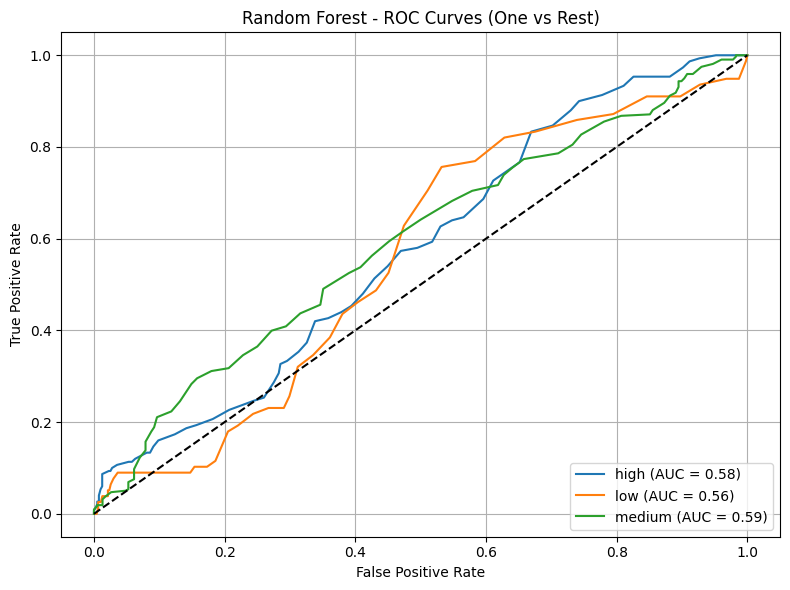

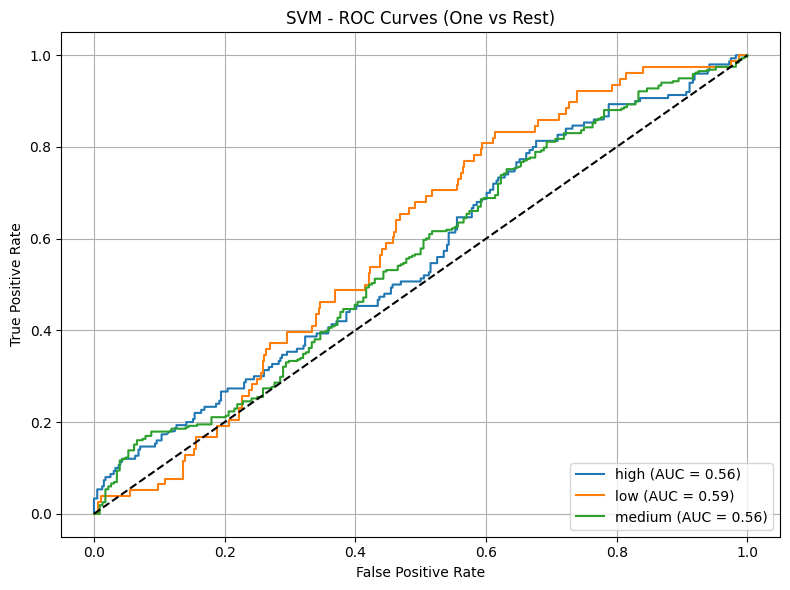

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize labels for ROC curves (multiclass one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 0=high, 1=low, 2=medium
n_classes = y_test_bin.shape[1]

# Models with probability output
rf = OneVsRestClassifier(models["Random Forest"])
svm = OneVsRestClassifier(models["SVM"])

# Fit models (if not already fit as OneVsRest)
rf.fit(X_train, label_binarize(y_train, classes=[0, 1, 2]))
svm.fit(X_train, label_binarize(y_train, classes=[0, 1, 2]))

# Predict probabilities
rf_probs = rf.predict_proba(X_test)
svm_probs = svm.predict_proba(X_test)

# Plot ROC curves
def plot_roc_curves(y_test_bin, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(label_encoder.classes_):
        plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curves (One vs Rest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for both models
plot_roc_curves(y_test_bin, rf_probs, "Random Forest")
plot_roc_curves(y_test_bin, svm_probs, "SVM")


In [38]:
## Define CCNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class CCNN(nn.Module):
    def __init__(self, n_rois=100, reduced_dim=100, n_classes=3):  
        super(CCNN, self).__init__()
        self.n_rois = n_rois
        self.reduced_dim = reduced_dim

        # Row-wise 1D conv over reduced_dim columns (per ROI)
        self.row_conv = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=reduced_dim)
        self.col_conv = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)

        self.fc1 = nn.Linear(128, 96)
        self.dropout = nn.Dropout(p=0.4)
        self.out = nn.Linear(96, n_classes)

    def forward(self, x):
        # Expect input shape: (B, 1, n_rois, reduced_dim)
        if x.ndim == 3:
            x = x.unsqueeze(1)  # Add channel dim → (B, 1, n_rois, reduced_dim)
        
        B = x.size(0)

        x = x.squeeze(1)                                 # → (B, n_rois, reduced_dim)
        x = x.view(B * self.n_rois, 1, self.reduced_dim) # → (B*n_rois, 1, reduced_dim)

        x = self.row_conv(x)                             # → (B*n_rois, 64, 1)
        x = F.relu(x).squeeze(-1)                        # → (B*n_rois, 64)

        x = x.view(B, self.n_rois, -1)                   # → (B, n_rois, 64)
        x = x.transpose(1, 2)                            # → (B, 64, n_rois)

        x = self.col_conv(x)                             # → (B, 128, n_rois)
        x = F.relu(x)
        x = torch.mean(x, dim=2)                         # → (B, 128)

        x = self.dropout(F.relu(self.fc1(x)))            # → (B, 96)
        x = self.out(x)                                  # → (B, n_classes)

        return x



In [39]:
# FC matrices to tensors, group aware split
x_fc_matrices = np.concatenate(all_fc_matrices, axis=0)  
print("X_fc_matrices shape:", X_fc_matrices.shape)


anxiety_classes = []
for df in all_labels:
    anxiety_classes.extend(df['binned_by_mean'].values)
anxiety_classes = np.array(anxiety_classes)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(anxiety_classes)
print("y_encoded shape:", y_encoded.shape) 

from sklearn.model_selection import GroupShuffleSplit

# Create subject labels for each window
subject_ids_expanded = []
for sub_name, fc in zip(valid_subjects, all_fc_matrices):
    subject_ids_expanded.extend([sub_name] * fc.shape[0])
subject_ids_expanded = np.array(subject_ids_expanded)

# Group-aware split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_fc_matrices, y_encoded, groups=subject_ids_expanded))

X_train_np, X_test_np = X_fc_matrices[train_idx], X_fc_matrices[test_idx]
y_train_np, y_test_np = y_encoded[train_idx], y_encoded[test_idx]

# Convert each (100, 100) FC matrix into (1, 100, 100)
x_tensor = torch.tensor(x_fc_matrices).float().unsqueeze(1)

y_tensor = torch.tensor(y_encoded).long()  

X_fc_matrices shape: (2730, 100, 100)
y_encoded shape: (2730,)


In [40]:
## Data Loader
import torch
from torch.utils.data import Dataset, DataLoader

class FCMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N, 1, 100, 100)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FCMatrixDataset(X_train_np, y_train_np)
test_dataset = FCMatrixDataset(X_test_np, y_test_np)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [41]:
## Training
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CCNN(n_rois=100, n_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/10 - Loss: 0.9956, Accuracy: 0.5499
Epoch 2/10 - Loss: 0.9277, Accuracy: 0.5829
Epoch 3/10 - Loss: 0.8952, Accuracy: 0.5875
Epoch 4/10 - Loss: 0.8330, Accuracy: 0.6186
Epoch 5/10 - Loss: 0.7521, Accuracy: 0.6731
Epoch 6/10 - Loss: 0.6703, Accuracy: 0.7120
Epoch 7/10 - Loss: 0.6049, Accuracy: 0.7454
Epoch 8/10 - Loss: 0.5253, Accuracy: 0.7839
Epoch 9/10 - Loss: 0.4577, Accuracy: 0.8201
Epoch 10/10 - Loss: 0.4014, Accuracy: 0.8356


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(all_true, all_preds))

Classification Report:
              precision    recall  f1-score   support

        high       0.48      0.76      0.59       150
         low       0.61      0.38      0.47        78
      medium       0.75      0.61      0.67       318

    accuracy                           0.62       546
   macro avg       0.61      0.59      0.58       546
weighted avg       0.66      0.62      0.62       546

Confusion Matrix:
[[114   0  36]
 [ 18  30  30]
 [104  19 195]]


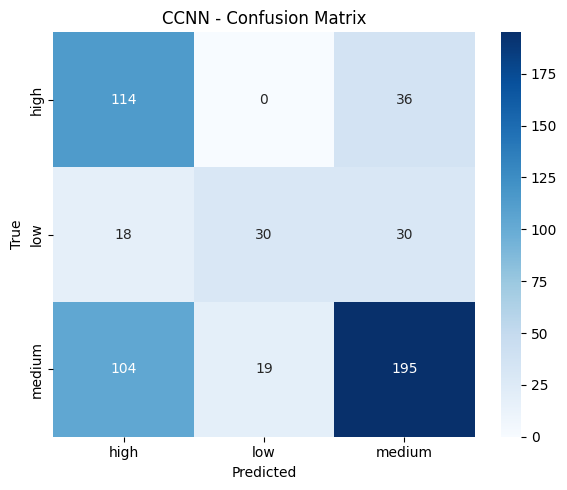

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CCNN - Confusion Matrix")
plt.tight_layout()
plt.show()

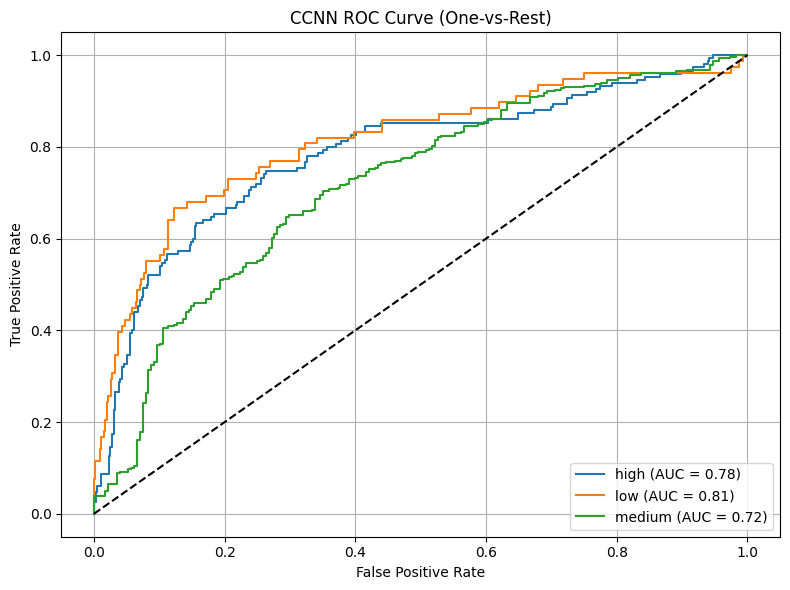

In [45]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

model.eval()
probs_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        probs_list.append(probs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

all_probs = np.vstack(probs_list)
all_true = np.concatenate(labels_list)

n_classes = len(np.unique(all_true))
y_test_bin = label_binarize(all_true, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CCNN ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
## PCA version of CCNN
from sklearn.decomposition import PCA

# Reduce from 100x100 to 100xN via PCA
pca_components = 40
X_pca_list = []

for mat in X_fc_matrices:
    pca = PCA(n_components=pca_components)
    reduced = pca.fit_transform(mat) 
    X_pca_list.append(reduced)

X_fc_pca = np.stack(X_pca_list) 

In [47]:
class PCAFCMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N, 1, 100, 40)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Recreate split
X_pca_train = X_fc_pca[train_idx]
X_pca_test = X_fc_pca[test_idx]
y_pca_train = y_encoded[train_idx]
y_pca_test = y_encoded[test_idx]

train_pca_dataset = PCAFCMatrixDataset(X_pca_train, y_pca_train)
test_pca_dataset = PCAFCMatrixDataset(X_pca_test, y_pca_test)

train_pca_loader = DataLoader(train_pca_dataset, batch_size=32, shuffle=True)
test_pca_loader = DataLoader(test_pca_dataset, batch_size=64, shuffle=False)

In [48]:
# Re run CNN with PCA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model_pca = CCNN(n_rois=100, reduced_dim=pca_components, n_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_pca.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_pca_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_pca(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_pca_loader.dataset)
    epoch_acc = correct / len(train_pca_loader.dataset)
    print(f"[Train PCA] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

[Train PCA] Epoch 1/10 - Loss: 0.9941, Accuracy: 0.5440
[Train PCA] Epoch 2/10 - Loss: 0.9541, Accuracy: 0.5824
[Train PCA] Epoch 3/10 - Loss: 0.9520, Accuracy: 0.5824
[Train PCA] Epoch 4/10 - Loss: 0.9518, Accuracy: 0.5824
[Train PCA] Epoch 5/10 - Loss: 0.9537, Accuracy: 0.5824
[Train PCA] Epoch 6/10 - Loss: 0.9541, Accuracy: 0.5824
[Train PCA] Epoch 7/10 - Loss: 0.9533, Accuracy: 0.5824
[Train PCA] Epoch 8/10 - Loss: 0.9518, Accuracy: 0.5824
[Train PCA] Epoch 9/10 - Loss: 0.9469, Accuracy: 0.5824
[Train PCA] Epoch 10/10 - Loss: 0.9507, Accuracy: 0.5824


In [52]:
## Try binary classification (high vs. low)
# Filter out "medium" samples 
import numpy as np

# Keep only "high" and "low"
keep_mask = np.isin(anxiety_classes, ['high', 'low'])

X_binary = X_fc_matrices[keep_mask]
labels_binary = np.array(anxiety_classes)[keep_mask]
subjects_binary = np.array(subject_ids_expanded)[keep_mask]


# Relabel with bianary
from sklearn.preprocessing import LabelEncoder

label_encoder_bin = LabelEncoder()
y_binary_encoded = label_encoder_bin.fit_transform(labels_binary)  # 'high'→1, 'low'→0

print(label_encoder_bin.classes_)

['high' 'low']


In [54]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_bin, test_idx_bin = next(gss.split(X_binary, y_binary_encoded, groups=subjects_binary))

X_train_bin = X_binary[train_idx_bin]
X_test_bin = X_binary[test_idx_bin]
y_train_bin = y_binary_encoded[train_idx_bin]
y_test_bin = y_binary_encoded[test_idx_bin]

In [55]:
class FCMatrixDatasetBinary(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N, 1, 100, 100)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_bin_dataset = FCMatrixDatasetBinary(X_train_bin, y_train_bin)
test_bin_dataset = FCMatrixDatasetBinary(X_test_bin, y_test_bin)

train_bin_loader = DataLoader(train_bin_dataset, batch_size=32, shuffle=True)
test_bin_loader = DataLoader(test_bin_dataset, batch_size=64, shuffle=False)

In [60]:
## Training Loop - Binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate binary CCNN mode
model_bin = CCNN(n_rois=100, reduced_dim=100, n_classes=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bin.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_bin.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_bin_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_bin(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_bin_loader.dataset)
    epoch_acc = correct / len(train_bin_loader.dataset)
    print(f"[Train Binary] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


[Train Binary] Epoch 1/10 - Loss: 0.6417, Accuracy: 0.6579
[Train Binary] Epoch 2/10 - Loss: 0.6223, Accuracy: 0.6579
[Train Binary] Epoch 3/10 - Loss: 0.5988, Accuracy: 0.6579
[Train Binary] Epoch 4/10 - Loss: 0.5177, Accuracy: 0.7160
[Train Binary] Epoch 5/10 - Loss: 0.3949, Accuracy: 0.8454
[Train Binary] Epoch 6/10 - Loss: 0.2720, Accuracy: 0.8980
[Train Binary] Epoch 7/10 - Loss: 0.2180, Accuracy: 0.9232
[Train Binary] Epoch 8/10 - Loss: 0.1705, Accuracy: 0.9496
[Train Binary] Epoch 9/10 - Loss: 0.1335, Accuracy: 0.9583
[Train Binary] Epoch 10/10 - Loss: 0.1359, Accuracy: 0.9529


In [61]:
# Evaluation
model_bin.eval()
test_loss = 0.0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_bin_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_bin(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_bin_loader.dataset)
test_acc = correct / len(test_bin_loader.dataset)

print(f"[Test Binary] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


[Test Binary] Loss: 0.5640, Accuracy: 0.7763


[Test Binary] Loss: 0.5640, Accuracy: 0.7763

Binary Classification Report (Low vs High):
              precision    recall  f1-score   support

        high       0.87      0.77      0.82       150
         low       0.64      0.78      0.71        78

    accuracy                           0.78       228
   macro avg       0.76      0.78      0.76       228
weighted avg       0.79      0.78      0.78       228

Confusion Matrix:
[[116  34]
 [ 17  61]]


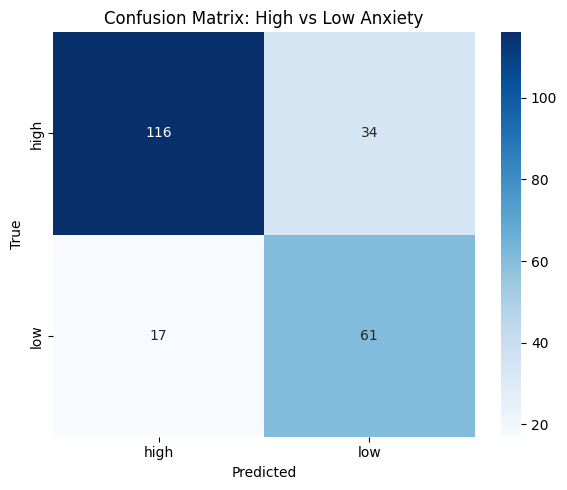

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model_bin.eval()

# Initialize
test_loss = 0.0
correct = 0
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in test_bin_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_bin(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

test_loss /= len(test_bin_loader.dataset)
test_acc = correct / len(test_bin_loader.dataset)

print(f"[Test Binary] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print("\nBinary Classification Report (Low vs High):")
print(classification_report(all_true, all_preds, target_names=label_encoder_bin.classes_))

cm = confusion_matrix(all_true, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_bin.classes_,
            yticklabels=label_encoder_bin.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: High vs Low Anxiety")
plt.tight_layout()
plt.show()


In [67]:
## Check class imbalance
import numpy as np
from collections import Counter

# Overall class distribution
print("Overall binary class distribution (0 = low, 1 = high):")
print(Counter(y_binary_encoded))

# Train set
print("\nTrain set distribution:")
print(Counter(y_train_bin))

# Test set
print("\nTest set distribution:")
print(Counter(y_test_bin))


Overall binary class distribution (0 = low, 1 = high):
Counter({0: 750, 1: 390})

Train set distribution:
Counter({0: 600, 1: 312})

Test set distribution:
Counter({0: 150, 1: 78})


In [73]:
## Resolve class imbalance, adjust class weights
model_weighted = CCNN(n_rois=100, reduced_dim=100, n_classes=2).to(device)

# Compute class weights and define weighted loss
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_bin),
                                     y=y_train_bin)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model_weighted.parameters(), lr=0.001)

# Re-train
num_epochs = 10
for epoch in range(num_epochs):
    model_weighted.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_bin_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_weighted(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_bin_loader.dataset)
    epoch_acc = correct / len(train_bin_loader.dataset)
    print(f"[Train Weighted] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

[Train Weighted] Epoch 1/10 - Loss: 0.6933, Accuracy: 0.5833
[Train Weighted] Epoch 2/10 - Loss: 0.6749, Accuracy: 0.6897
[Train Weighted] Epoch 3/10 - Loss: 0.5869, Accuracy: 0.6963
[Train Weighted] Epoch 4/10 - Loss: 0.4617, Accuracy: 0.8004
[Train Weighted] Epoch 5/10 - Loss: 0.3802, Accuracy: 0.8388
[Train Weighted] Epoch 6/10 - Loss: 0.2804, Accuracy: 0.8958
[Train Weighted] Epoch 7/10 - Loss: 0.2002, Accuracy: 0.9309
[Train Weighted] Epoch 8/10 - Loss: 0.1655, Accuracy: 0.9408
[Train Weighted] Epoch 9/10 - Loss: 0.1519, Accuracy: 0.9485
[Train Weighted] Epoch 10/10 - Loss: 0.1042, Accuracy: 0.9660


[Test Weighted] Loss: 0.5033, Accuracy: 0.7807, AUC: 0.8779

Classification Report (Default Threshold = 0.5):
              precision    recall  f1-score   support

        high       0.89      0.76      0.82       150
         low       0.64      0.82      0.72        78

    accuracy                           0.78       228
   macro avg       0.77      0.79      0.77       228
weighted avg       0.80      0.78      0.79       228



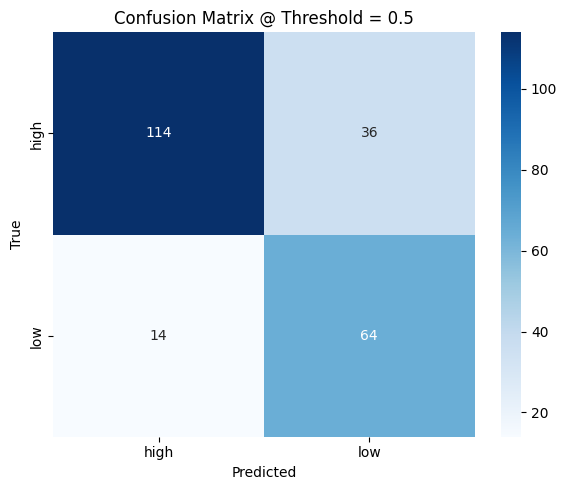

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

model_weighted.eval()

test_loss = 0.0
correct = 0
all_preds = []
all_true = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_bin_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_weighted(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        probs = F.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (high)
        all_probs.extend(probs.cpu().numpy())

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

test_loss /= len(test_bin_loader.dataset)
test_acc = correct / len(test_bin_loader.dataset)
auc_score = roc_auc_score(all_true, all_probs)

print(f"[Test Weighted] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC: {auc_score:.4f}")
print("\nClassification Report (Default Threshold = 0.5):")
print(classification_report(all_true, all_preds, target_names=label_encoder_bin.classes_))

# Confusion Matrix at 0.5 threshold
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_bin.classes_,
            yticklabels=label_encoder_bin.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix @ Threshold = 0.5")
plt.tight_layout()
plt.show()

In [88]:
# Determine optimal threshold
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []
recalls = []
precisions = []

for t in thresholds:
    preds = [1 if p >= t else 0 for p in all_probs]
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, preds, average='binary')
    f1_scores.append(f1)
    recalls.append(recall)
    precisions.append(precision)

# Get best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Recommended threshold: {best_threshold:.2f}")
print(f"F1 Score at best threshold: {best_f1:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}")

Recommended threshold: 0.64
F1 Score at best threshold: 0.7805
Precision: 0.7442, Recall: 0.8205


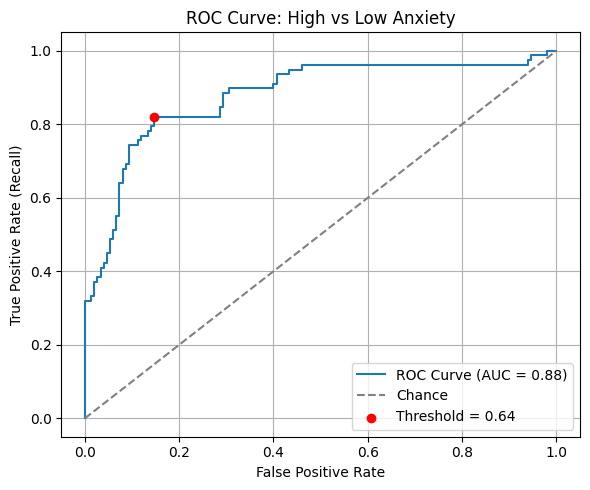

In [89]:
# Generate ROC data
fpr, tpr, thresholds = roc_curve(all_true, all_probs)

# Define your chosen threshold
threshold = 0.64
closest_idx = np.argmin(np.abs(thresholds - threshold))

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

# Mark chosen threshold
plt.scatter(fpr[closest_idx], tpr[closest_idx], color='red', label=f"Threshold = {threshold}", zorder=10)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve: High vs Low Anxiety")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report @ Threshold = 0.64:
              precision    recall  f1-score   support

        high       0.90      0.85      0.88       150
         low       0.74      0.82      0.78        78

    accuracy                           0.84       228
   macro avg       0.82      0.84      0.83       228
weighted avg       0.85      0.84      0.84       228



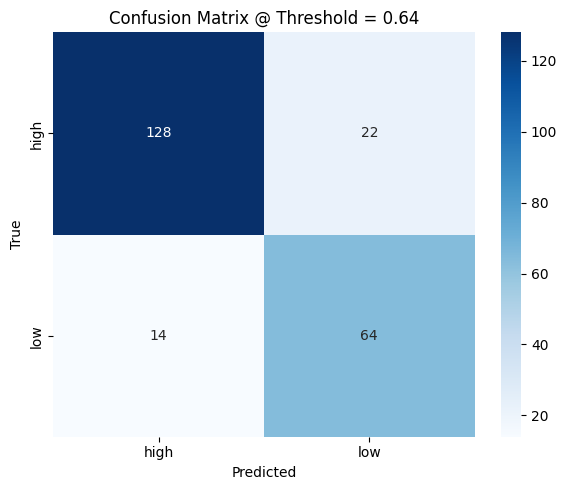

In [91]:
# Adjust Threshold
threshold = 0.64 
custom_preds = [1 if p >= threshold else 0 for p in all_probs]

print(f"\nClassification Report @ Threshold = {threshold}:")
print(classification_report(all_true, custom_preds, target_names=label_encoder_bin.classes_))

# Confusion Matrix
cm_thresh = confusion_matrix(all_true, custom_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_thresh, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_bin.classes_,
            yticklabels=label_encoder_bin.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix @ Threshold = {threshold}")
plt.tight_layout()
plt.show()
